# **Group Assignment** - Bike Sharing

Group 4:
- Alina Edigareva
- Yannish Bhandari
- Vitus Schlereth
- Susana Luna
- Gabriel Chapman

Provided Data:

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## Part 0: Libraries Import

In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, tune_model
from pycaret.regression import finalize_model,pull,create_model, predict_model,plot_model,get_config

## PART I: Exploratory Data Analysis

### Import Dataset

In [2]:
df = pd.read_csv("hour.csv")

### Dataset Initial Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


First Impressions:
- Dataset has no null values
- 16 possible features; cnt column is target
- cnt is in integer, so odds are a regression analysis is best fit since the output will need to be continuous
- Date column is in object, maybe it has to be converted to datetime
- The rest are either float or integer, pointing towards either discrete or continuous variables
- instant column seems to indicate "primary key", for it is a unique identificator of the record. This will be explored when dropping duplicates

### Date into Datetime Object

In [5]:
# Convert dteday into Datetime
df['date'] = pd.to_datetime(df['dteday'])
df = df.drop(columns="dteday") #drop the original dteday

#Reorganize to date is first column
cols = df.columns.tolist()
cols.remove('date')
cols.insert(1, 'date')
df = df[cols]

### Daylight Feature Creation

In [6]:
# Function to create a new column "Daylight" based on month and hour to account for geographical changes
def is_daylight(row):
    month = row['mnth']
    hour = row['hr']
    
    # Define daylight hours per month (simplified)
    if month in [1, 2, 3]:  # January, February, March
        start_hour, end_hour = 7, 18  # 7:00 AM to 6:00 PM
    elif month in [4, 5, 6, 7, 8]:  # April to August
        start_hour, end_hour = 6, 20  # 6:00 AM to 8:00 PM
    elif month in [9, 10]:  # September and October
        start_hour, end_hour = 7, 19  # 7:00 AM to 7:00 PM
    else:  # November and December
        start_hour, end_hour = 7, 17  # 7:00 AM to 5:00 PM
    
    # Return 1 if the hour is within the daylight window, 0 otherwise
    return "Yes" if start_hour <= hour < end_hour else "No"

# Apply the function to the DataFrame
df['Daylight'] = df.apply(is_daylight, axis=1)

### Season Mapping

- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)

In [7]:
# Mapping of integer codes to season names
season_mapping = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

# Create the 'seasons' column by mapping 'season' to season names
df['seasons'] = df['season'].map(season_mapping)

### Weather Situation Mapping

+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [8]:
# Mapping of integer codes to weather names
weather_mapping = {
    1: 'Clear',
    2: 'Misty',
    3: 'Light_Rain/Snow',
    4: 'Heavy_Rain/Snow'
}

# Create the 'seasons' column by mapping 'weather' to weather conditions
df['weather'] = df['weathersit'].map(weather_mapping)

### Extraction of Time features from Date

In [9]:
df['Year'] = df['date'].dt.year # Year
df['Month'] = df['date'].dt.month_name() # Name of Month
df['Day'] = df['date'].dt.day_name() # Name of Day

### Hour Shift Mapping

The idea is that at different time periods the demand might fluctuate

Weekdays:
- Between 3:00 and 7:00 --> Early Morning
- Between 7:00 and 11:00 --> Morning Rush
- Between 11:00 and 15:00 --> Afternoon
- Between 15:00 and 21:00 --> Afternoon Rush
- Between 21:00 and 3:00 --> Late Night

Weekends (Saturday and Sunday):
- Between 4:00 and 11:00 --> Early Morning
- Between 11:00 and 18:00 --> Afternoon
- Between 18:00 and 4:00 --> Late Night

In [10]:
# Define a function to map hours to time-of-day categories
def map_hour_to_shift(hour, day):
    # Check if the day is a weekend (Saturday or Sunday)
    if day in ['Saturday', 'Sunday']:
        if 4 <= hour < 11:
            return 'Early_Morning'
        elif 11 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Late_Night'
    else:  # Monday to Friday
        if 3 <= hour < 7:
            return 'Early_Morning'
        elif 7 <= hour < 11:
            return 'Morning_Rush'
        elif 11 <= hour < 15:
            return 'Afternoon'
        elif 15 <= hour < 21:
            return 'Afternoon_Rush'
        else:
            return 'Late_Night'


# Apply the function to create a new column 'shift'
df['shift'] = df.apply(lambda row: map_hour_to_shift(row['hr'], row['Day']), axis=1)


### Year to Quarter Mapping

In [11]:
# Define a function to map hours to time-of-day categories
def map_month_to_quarter(month):
    if 1 <= month < 4:
        return 'Q1'
    elif 4 <= month < 7:
        return 'Q2'
    elif 7 <= month < 10:
        return 'Q3'
    elif 10 <= month <= 12:
        return 'Q4'
    else:
        return 'CHECK_MONTH'

# Apply the function to create a new column 'shift'
df['quarter'] = df['mnth'].apply(map_month_to_quarter)

### Denormalization of Values

- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)

In [12]:
temp_max = 41
atemp_max = 50
hum_max = 100
windspeed_max = 67

df['real_temp'] = round(df['temp']*temp_max,1)
df['real_atemp'] = round(df['atemp']*atemp_max,1)
df['real_hum'] = round(df['hum']*hum_max,1)
df['real_windspeed'] = round(df['windspeed']*windspeed_max,1)

### Historical Data of bikes used

In [13]:
df['Previous_Count'] = df['cnt'].shift(1) # Previous hour
df['Previous_Shift_Mean'] = df['cnt'].rolling(6).mean() # Average of last 6 hours
df['Previous_Day'] = df['cnt'].shift(24)  # Previous day


In [14]:
df = df.dropna(axis=0) # Reset values since rolling and shift values create nulls

### Cylclical Time Features

Time has to be treated cyclical, because if time is considered where month 12 (December) is 12x more than month 1 (January), then the model might incorrectly evaluate time features. 

To complement OHEncoded features, the cyclical feature can measure the continuous changes in count per hour

In [15]:
# Assuming df is your DataFrame with 'Month' and 'Day' as text columns; hr numerical column

# Convert month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 
    'May': 5, 'June': 6, 'July': 7, 'August': 8, 
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['Monthnum'] = df['Month'].map(month_map)

# Convert day names to numbers
day_map = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
    'Friday': 5, 'Saturday': 6, 'Sunday': 7
}
df['Daynum'] = df['Day'].map(day_map)

# Add cyclical features for 'Month' and 'Day' and 'hr'
df['month_sin'] = np.sin(2 * np.pi * df['Monthnum'] / 12).astype(float)
df['month_cos'] = np.cos(2 * np.pi * df['Monthnum'] / 12).astype(float)
df['day_sin'] = np.sin(2 * np.pi * df['Daynum'] / 7).astype(float)
df['day_cos'] = np.cos(2 * np.pi * df['Daynum'] / 7).astype(float)
df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24).astype(float)
df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24).astype(float)

# Drop the intermediate numerical columns
df.drop(['Monthnum', 'Daynum'], axis=1, inplace=True)

### Handling Index

In [16]:
df = df.drop(columns=["instant"]) # instant seems to behave like the index

In [17]:
# Assigning Date as the index
#df = df.set_index("date")

## Data Visualization VITUS

Put code of Data Viz here

## Preparing Data Structure prior to Model Selection (Pycaret)

### Dropping Features used to create new ones 
To prevent the model to pick two features from the same style

In [18]:
# Assuming registered and casual are not part of the model
df = df.drop(columns=["casual","registered"])

In [19]:
# Dropping binary categorical columns for created text columns and normalized columns
df = df.drop(columns=['yr',
 'mnth',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season',
 'weekday',
 'weathersit'])

### Ensuring proper datatype for different variables

In [20]:
# Convert holiday and Year into object to run a smooth OHE
df = df.astype({
    "holiday": object,
    "Year": object,
    "workingday":object,
    'Daylight' : object,
    'hr': object
})

### Outlier Removal

In [21]:
outlier_columns = ['cnt','real_windspeed', 'Previous_Count', 'Previous_Shift_Mean','Previous_Day']

In [22]:
def drop_outliers_iqr(df, columns=None,multiplier = 3):

    if columns is None:
        columns = df.select_dtypes(include='number').columns  # Apply to all numeric columns if none specified
    
    # Calculate Q1, Q3, and IQR for each specified column
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    
    
    # Construct a mask to filter rows
    mask = ((df[columns] >= (Q1 - multiplier * IQR)) & (df[columns] <= (Q3 + multiplier * IQR))).all(axis=1)
    
    # Return DataFrame with preserved index
    return df[mask].reset_index(drop=True)

# Drop outliers
df_final = drop_outliers_iqr(df,outlier_columns)

In [23]:
# Calculate and print the percentage of rows considered outliers
num_outliers = len(df) - len(df_final)
percent_outliers = (num_outliers / len(df)) * 100
print(f"Percentage of rows considered outliers: {percent_outliers:.2f}%")

Percentage of rows considered outliers: 0.06%


In [24]:
len(df_final)

17345

## PART II: Prediction Model

### Model Selection in Pycaret Document

In [25]:
# Replace spaces with underscores to ensure no troubleshooting with Pycaret
df_final.columns = df.columns.str.replace(' ', '_')

In [26]:
# List of categorical columns
categorical_columns = df_final.select_dtypes(include=['object']).columns.tolist()

# List of numerical columns
numerical_columns = df_final.select_dtypes(include=['number']).columns.drop("cnt").tolist()

In [27]:
categorical_columns

['hr',
 'holiday',
 'workingday',
 'Daylight',
 'seasons',
 'weather',
 'Year',
 'Month',
 'Day',
 'shift',
 'quarter']

In [28]:
numerical_columns

['real_temp',
 'real_atemp',
 'real_hum',
 'real_windspeed',
 'Previous_Count',
 'Previous_Shift_Mean',
 'Previous_Day',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'hour_sin',
 'hour_cos']

In [29]:
len(df_final.columns) - len(numerical_columns) - len(categorical_columns) -1 == 0

False

### Pycaret Setup

In [30]:
# Pycaret Setup

model = setup(
    
    #Basic
    data = df_final, #Index was set at date for Dataviz purposes, but Pycaret needs default index format
    target = "cnt",
    train_size = 0.8, # Train size of 80%

    preprocess = True,
    categorical_features = categorical_columns, #This runs OHE for multiclass categories and Ordinal for binary categories
    numeric_features= numerical_columns, #Features will be standarized via Standard Scaler based on zscore method
    
    #Feature Normalization
    normalize=True,
    normalize_method='zscore',

    #Transformation
    transformation = True,
    transformation_method='yeo-johnson', #Ensure proper handling of values and normalize the distribution

    # Dimensionality Reduction
    pca = False, #Not desired

    #Multicollinearity
    remove_multicollinearity=True,
    multicollinearity_threshold=0.80,#Features showing correlation of 80% or above are dropped

    #Feature Selection
    feature_selection=True,
    feature_selection_method="classic", #SelectFromModel function from scikit-learn: top 20% of features will be used

    #Paralellization Options
    n_jobs = -1,
    use_gpu= False,    
    
    html = True,
    session_id = None
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 13876, number of used features: 72
[LightGBM] [Info] Start training from score 190.111271


,Description,Value
0,Session id,549
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17345, 26)"
4,Transformed data shape,"(17345, 6)"
5,Transformed train set shape,"(13876, 6)"
6,Transformed test set shape,"(3469, 6)"
7,Ordinal features,4
8,Numeric features,13
9,Date features,1


### Model Comparison based on Root Mean Squared Error and 5 folds of cross validation

In [31]:
models = compare_models(sort = "RMSE", exclude=[],fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,26.6931,1999.5873,44.7005,0.9395,0.3593,0.3346,2.2440
lightgbm,Light Gradient Boosting Machine,27.2406,2062.7737,45.4027,0.9375,0.3684,0.3645,0.7840
et,Extra Trees Regressor,27.2112,2122.0560,46.0588,0.9357,0.3531,0.3243,1.0300
rf,Random Forest Regressor,27.3207,2157.8326,46.4298,0.9347,0.3497,0.3240,1.4960
xgboost,Extreme Gradient Boosting,28.0970,2236.6756,47.2724,0.9323,0.3541,0.3347,0.7120
knn,K Neighbors Regressor,29.2175,2440.6922,49.3907,0.9261,0.3670,0.3490,0.6940
gbr,Gradient Boosting Regressor,31.8919,2503.8214,50.0134,0.9242,0.4152,0.4308,0.8460
dt,Decision Tree Regressor,36.6742,4018.7401,63.3737,0.8782,0.4653,0.4011,0.6140
ada,AdaBoost Regressor,65.6384,6279.2241,79.1642,0.8098,1.0400,2.7592,0.8540
br,Bayesian Ridge,71.3820,9182.4181,95.8099,0.7218,0.9797,2.9279,0.6220


#### Extract Model Name

In [32]:
# Manually map the short names to model classes
model_mapping = {
    'lr': 'LinearRegression',
    'lasso': 'Lasso',
    'ridge': 'Ridge',
    'en': 'ElasticNet',
    'lar': 'Lars',
    'llar': 'LassoLars',
    'omp': 'OrthogonalMatchingPursuit',
    'br': 'BayesianRidge',
    'ard': 'ARDRegression',
    'par': 'PassiveAggressiveRegressor',
    'ransac': 'RANSACRegressor',
    'tr': 'TheilSenRegressor',
    'huber': 'HuberRegressor',
    'kr': 'KernelRidge',
    'svm': 'SVR',
    'knn': 'KNeighborsRegressor',
    'dt': 'DecisionTreeRegressor',
    'rf': 'RandomForestRegressor',
    'et': 'ExtraTreesRegressor',
    'ada': 'AdaBoostRegressor',
    'gbr': 'GradientBoostingRegressor',
    'mlp': 'MLPRegressor',
    'xgboost': 'XGBRegressor',
    'lightgbm': 'LGBMRegressor',
    'catboost': 'CatBoostRegressor',
}


# Find the short name for the best model
for short_name, model_name in model_mapping.items():
    if type(models).__name__ == model_name:
        best_model_short_name = short_name
        break

best_model_short_name.__str__

best_model_short_name

'catboost'

### Create best model based on model selected after comparison

In [33]:
best_model = create_model(best_model_short_name, fold = 5, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,25.92,1882.42,43.39,0.94,0.35,0.33
1,26.65,2014.02,44.88,0.94,0.37,0.34
2,26.98,2024.92,45.00,0.94,0.35,0.32
3,27.55,2181.95,46.71,0.94,0.35,0.32
4,26.37,1894.63,43.53,0.94,0.38,0.36
Mean,26.69,1999.59,44.70,0.94,0.36,0.33
Std,0.55,108.49,1.21,0.00,0.01,0.01


### Tune Model with default hyperparameter tuning values

In [34]:
tuned_model = tune_model(best_model,optimize="RMSE")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
# Finalize the model to make it ready for predictions
final_model = finalize_model(tuned_model)

In [36]:
predictions = predict_model(final_model,df_final.reset_index())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,22.9400,1375.8782,37.0928,0.9582,0.3373,0.3087


In [37]:
# Ensure non-negative and rounded predictions
if 'prediction_label' in predictions.columns:
    predictions['prediction_label'] = predictions['prediction_label'].apply(lambda x: max(round(x, 0), 0))
else:
    print("Error: 'prediction_label' column not found in predictions.")



In [38]:
final_model = finalize_model(tuned_model)

# Combine X_train and y_train to create a full training dataset
X_train = get_config('X_train')
y_train = get_config('y_train')
train_data = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test to create a full test dataset
X_test = get_config('X_test')
y_test = get_config('y_test')
test_data = pd.concat([X_test, y_test], axis=1)

# Train metrics
train_predictions = predict_model(final_model, data=train_data)
train_metrics = pull()
print("Training Metrics:")
print(train_metrics)

# Test metrics
test_predictions = predict_model(final_model, data=test_data)
test_metrics = pull()
print("\nTest Metrics:")
print(test_metrics)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,23.0339,1387.2191,37.2454,0.9580,0.3393,0.3128


Training Metrics:
                Model      MAE        MSE     RMSE     R2   RMSLE    MAPE
0  CatBoost Regressor  23.0339  1387.2191  37.2454  0.958  0.3393  0.3128


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,22.5645,1330.5146,36.4762,0.9592,0.3291,0.2923



Test Metrics:
                Model      MAE        MSE     RMSE      R2   RMSLE    MAPE
0  CatBoost Regressor  22.5645  1330.5146  36.4762  0.9592  0.3291  0.2923


In [39]:
predictions[['cnt','prediction_label']]

,cnt,prediction_label
0,17,20.0
1,17,11.0
2,9,11.0
3,6,5.0
4,3,5.0
...,...,...
17340,119,95.0
17341,89,86.0
17342,90,69.0
17343,61,67.0


In [40]:
predictions.columns

Index(['index', 'date', 'hr', 'holiday', 'workingday', 'Daylight', 'seasons',
       'weather', 'Year', 'Month', 'Day', 'shift', 'quarter', 'real_temp',
       'real_atemp', 'real_hum', 'real_windspeed', 'Previous_Count',
       'Previous_Shift_Mean', 'Previous_Day', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'cnt',
       'prediction_label'],
      dtype='object')

In [41]:
print(final_model.feature_names_)


['real_temp', 'Previous_Count', 'Previous_Day', 'hour_sin', 'hour_cos']


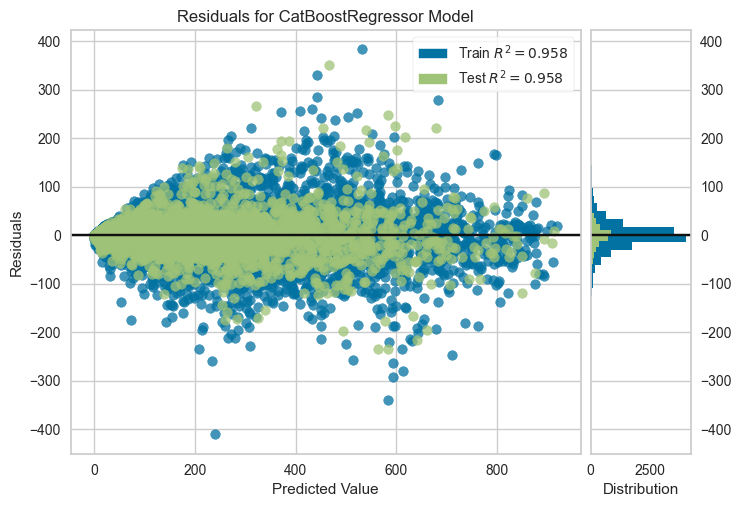

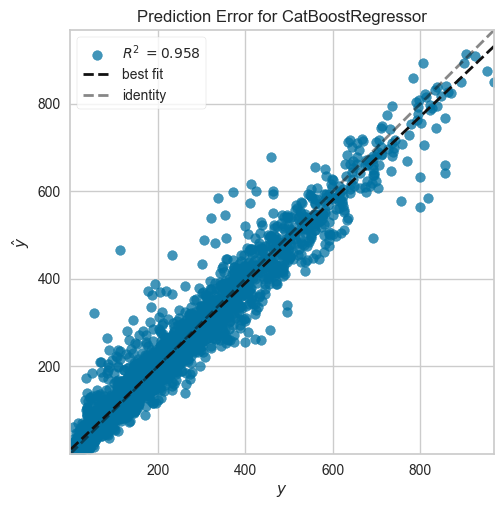

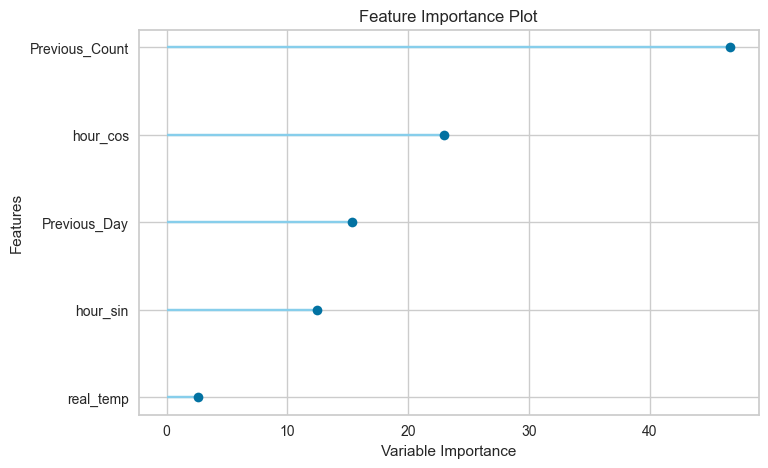

In [42]:
plot_model(final_model, plot='residuals')
plot_model(final_model, plot='error')
plot_model(final_model, plot='feature')

### Prediction Graphs

In [47]:
predictions.columns

Index(['index', 'date', 'hr', 'holiday', 'workingday', 'Daylight', 'seasons',
       'weather', 'Year', 'Month', 'Day', 'shift', 'quarter', 'real_temp',
       'real_atemp', 'real_hum', 'real_windspeed', 'Previous_Count',
       'Previous_Shift_Mean', 'Previous_Day', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'cnt',
       'prediction_label'],
      dtype='object')

In [48]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


# 1. Time Series Plot for Actual vs Predicted Counts
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=predictions['date'], y=predictions['cnt'],
                          mode='lines', name='Actual Count',
                          line=dict(color='blue')))
fig1.add_trace(go.Scatter(x=predictions['date'], y=predictions['prediction_label'],
                          mode='lines', name='Predicted Count',
                          line=dict(color='red')))

fig1.update_layout(
    title='Actual vs Predicted Counts Over Time',
    xaxis_title='Date',
    yaxis_title='Bike Count',
    template='plotly_white'
)
fig1.show()

# 2. Residual Plot (Residuals = Actual - Predicted)
predictions['residuals'] = predictions['cnt'] - predictions['prediction_label']
fig2 = px.scatter(predictions, x='date', y='residuals',
                  title='Residual Plot (Actual - Predicted)',
                  labels={'date': 'Date', 'residuals': 'Residuals'})
fig2.update_traces(marker=dict(color='orange'))
fig2.update_layout(template='plotly_white')
fig2.show()

# 3. Scatter Plot for Predicted vs Actual Counts
fig3 = px.scatter(predictions, x='cnt', y='prediction_label',
                  title='Predicted vs Actual Counts',
                  labels={'cnt': 'Actual Count', 'prediction_label': 'Predicted Count'})
fig3.add_shape(
    # Adding line y=x for visual reference
    type='line', x0=predictions['cnt'].min(), y0=predictions['cnt'].min(), x1=predictions['cnt'].max(), y1=predictions['cnt'].max(),
    line=dict(color='green', dash='dash')
)
fig3.update_traces(marker=dict(color='purple'))
fig3.update_layout(template='plotly_white')
fig3.show()


## PART III: Streamlit dashboard

In [44]:
### This part goes in a separate script ###